# Simulations: Network Structure

In [1]:
# Imports
import numpy as np
import gmpy2
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns


gmpy2.get_context().precision = 113  # 113 bits ≈ quad precision

# Setting the color palette for the plots
sns.set_theme(style='whitegrid', palette="pastel")

### Importing Quickscore

In [2]:
import importlib
from quickscore import fun_quickscoreW2_gmpy2

### Importing metric function

In [3]:
import metrics
importlib.reload(metrics)
from metrics import compute_metrics

## Fixed Values

In [4]:
np.random.seed(42)  # to reproduce results

# Parameters

# Number of diseases
n_disease = 30

# Number of tests
n_test = 50

# Typical number of diagnoses, should be smaller than n_deases/2
expected_number_of_diseases = 4

# Uniform Distribution of Prevalences
prev = np.full(n_disease, expected_number_of_diseases/n_disease)

# Sensitivity - for all connections
sensitivity = 0.4

# Three Structures

## 1. Random Bipartite Structure


In [6]:
def random_structure(sparseness, other_metrics = False):

    connections = np.random.rand(n_test, n_disease) < sparseness  # Selection of connections
    sensorig = np.full((n_test, n_disease), sensitivity ) * connections

    flag = 1
    attempt = 0
    max_att = 3000
    
    while flag and attempt<max_att:
        #actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
        # Forces constant ndiags=2
        actualdiags = np.random.choice(n_disease, size=2, replace=False)  # Generate diseases
        ndiags = len(actualdiags)

        testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

        postest = np.where(testresults == 1)[0]
        negtest = np.where(testresults == 0)[0]
        m = len(postest)

        if 10<m<15:
            flag = 0  # Exit loop if conditions met
#             print(f"m: {m}, ndiags: {ndiags}")
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
#         else:
# #             print(f"ndiags:{ndiags}")
#              print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")
        attempt += 1
    
    if flag:
        print("Failed to find valid test result configuration.")
        return None, connections

    # Prepare data for Quickscore algorithm
    sens = sensorig[postest, :]                 
    sensneg = sensorig[negtest, :] 

    pfmin = 1 - sens    

    pfminneg = np.prod(1 - sensneg, axis=0)     

    # Quickscore calculation
    posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

    actualdiseases = np.zeros_like(prev)
    actualdiseases[actualdiags] = 1

    # Metric Calculation
    loss = log_loss(actualdiseases, posteriorg)
    
    if other_metrics:
        metrics = compute_metrics(actualdiseases, posteriorg)
        precision = metrics["precision"]
        recall = metrics["recall"]
        f1 = metrics["f1_score"]
        return loss, precision, recall, f1, connections

    return loss, connections

### Sparseness

In [7]:
# Number of trials
n_trials = 5

sparseness_options = np.linspace(0.1, 1, 20)

losses = np.empty(len(sparseness_options))
losses_trial = np.empty(n_trials)


# Running the algorithm with random structures for different sparseness values 
for i, sparseness in enumerate(sparseness_options):
    print(i)
    sparseness = sparseness_options[i]
    
    for j in range(n_trials):
        loss, _ = random_structure(sparseness)
        
        losses_trial[j] = loss
    losses[i] = np.nanmean(losses_trial)

0
Failed to find valid test result configuration.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Failed to find valid test result configuration.
15
Failed to find valid test result configuration.
Failed to find valid test result configuration.
16
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
17
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
18


C:\Users\anale\AppData\Local\Temp\ipykernel_2056\2831514216.py:19: RuntimeWarning: Mean of empty slice
  losses[i] = np.nanmean(losses_trial)


Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
19
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.


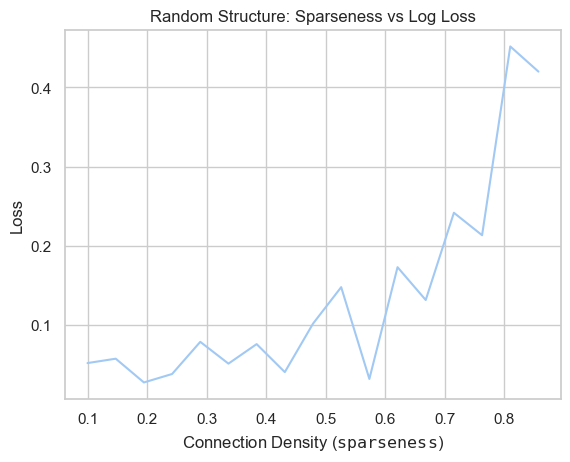

In [8]:
plt.figure()
plt.plot(sparseness_options, losses)
plt.title("Random Structure: Sparseness vs Log Loss")
plt.xlabel(r"Connection Density ($\mathtt{sparseness}$)")
plt.ylabel("Loss")

plt.savefig("sp2-A.pdf", dpi=300, bbox_inches='tight')

## Preferential Attachment Structure


In [9]:
def preferential_structure(n_common_test, p_common = 0.7 , p_noncom = 0.2, other_metrics=False):

    connections = np.zeros((n_test,n_disease), dtype=bool)

    # Choose some findings to be the ones that are connected to a lot of diseases - parameter n_common_test
    common_test = np.random.choice(n_test, n_common_test, replace=False)

    # Assigning more connections to common findings
    for t in range(n_test):
        if t in common_test:
            connections[t,:] = np.random.rand(n_disease) < p_common
        else:
            connections[t,:] = np.random.rand(n_disease) < p_noncom

    sensorig = np.full((n_test, n_disease), sensitivity ) * connections


    flag = 1
    attempt = 0
    max_att = 3000
    
    while flag and attempt<max_att:
        #actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate disease
        # Forces constant ndiags
        actualdiags = np.random.choice(n_disease, size=2, replace=False)  # Generate diseases
        ndiags = len(actualdiags)

        testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

        postest = np.where(testresults == 1)[0]
        negtest = np.where(testresults == 0)[0]
        m = len(postest)

        if 10<m<15:
             flag = 0  # Exit loop if conditions met
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
#         else:
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

        attempt += 1
    
    if flag:
        print("Failed to find valid test result configuration.")
        return None, connection
    # Prepare data for Quickscore algorithm
    sens = sensorig[postest, :]                 
    sensneg = sensorig[negtest, :]              
    pfmin = 1 - sens                          
    pfminneg = np.prod(1 - sensneg, axis=0)     


    # Quickscore calculation
    posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

    actualdiseases = np.zeros_like(prev)
    actualdiseases[actualdiags] = 1

    # Metric Calculation
    loss = log_loss(actualdiseases, posteriorg)
    
    if other_metrics:
        metrics = compute_metrics(actualdiseases, posteriorg)
        precision = metrics["precision"]
        recall = metrics["recall"]
        f1 = metrics["f1_score"]
        return loss, precision, recall, f1, connections
    
    return loss, connections


### n_common_test


In [10]:
# n_trials
n_trials = 5

n_common_test_options = np.arange(1, 31, 2)

pref_losses = np.empty(len(n_common_test_options))
losses_trial = np.empty(n_trials)

for i, n in enumerate(n_common_test_options):
    print(i)
    
    for j in range(n_trials):
        loss, _ = preferential_structure(n, 0.7, 0.2)
        losses_trial[j] = loss
        
    pref_losses[i] = np.nanmean(losses_trial)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


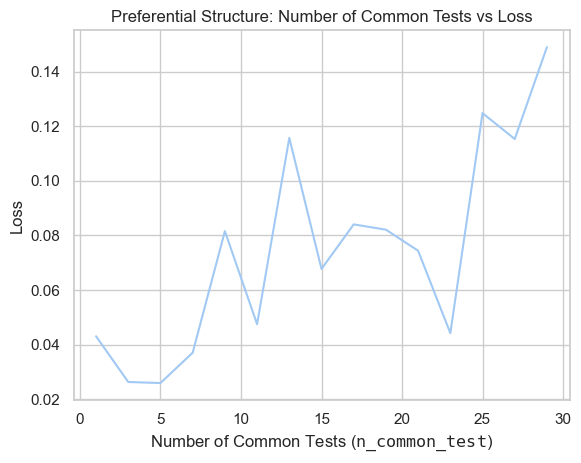

In [14]:
plt.figure()
plt.plot(n_common_test_options, pref_losses)
plt.title("Preferential Structure: Number of Common Tests vs Loss")
plt.xlabel(r"Number of Common Tests ($\mathtt{n\_common\_test}$)")
plt.ylabel("Loss")

plt.savefig("sp2-B.pdf", dpi=300, bbox_inches='tight')

## Clustered Structure

In [16]:
def clustered_structure(n_clusters, p_within = 0.7, p_out = 0.2, other_metrics=False):
    # Define arbitrary number of clusters n_clusters

    # Randomly assign clusters to nodes
    disease_clusters = np.random.randint(0, n_clusters, size=n_disease)  
    finding_clusters = np.random.randint(0, n_clusters, size=n_test)  


    connections = np.zeros((n_test, n_disease))

    # Loop through tests and diseases, if a pair belongs to the same cluster, connect them with a high probability
    
    for i in range(n_test):
        for j in range(n_disease):
            if finding_clusters[i] == disease_clusters[j]:  
                connections[i, j] = np.random.rand() < p_within
            else:
                connections[i, j] = np.random.rand() < p_out

    sensorig = np.full((n_test, n_disease), sensitivity ) * connections

    flag = 1
    attempt = 0
    max_att = 3000
    while flag and attempt<max_att:
        #actualdiags = np.where(np.random.rand(n_disease) < prev)[0]  # Generate diseases
        # Forces constant ndiags
        actualdiags = np.random.choice(n_disease, size=2, replace=False)  # Generate diseases
        ndiags = len(actualdiags)

        testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

        postest = np.where(testresults == 1)[0]
        negtest = np.where(testresults == 0)[0]
        m = len(postest)

        if 10<m<15:
            flag = 0  # Exit loop if conditions met
            #print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
#         else:
#             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")
        
        attempt += 1
    if flag:
        print("Failed to find valid test result configuration.")
        return None, connections
    # Prepare data for Quickscore algorithm
    sens = sensorig[postest, :]                 
    sensneg = sensorig[negtest, :]              
    pfmin = 1 - sens                          
    pfminneg = np.prod(1 - sensneg, axis=0)     


    # Quickscore calculation
    posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

    actualdiseases = np.zeros_like(prev)
    actualdiseases[actualdiags] = 1

    # Metric Calculation
    loss = log_loss(actualdiseases, posteriorg)
    
    if other_metrics:
        metrics = compute_metrics(actualdiseases, posteriorg)
        precision = metrics["precision"]
        recall = metrics["recall"]
        f1 = metrics["f1_score"]
        return loss, precision, recall, f1, connections

    return loss, connections



### n_clusters
 

In [17]:
# n_trials
n_trials = 5

n_clusters_options = np.arange(1, 15)  

clus_losses = np.empty(len(n_clusters_options))
losses_trial = np.empty(n_trials)

for i, n in enumerate(n_clusters_options):
    print(i)
    
    for j in range(n_trials):
        loss, _ = clustered_structure(n)
        losses_trial[j] = loss
        
    clus_losses[i] = np.nanmean(losses_trial)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


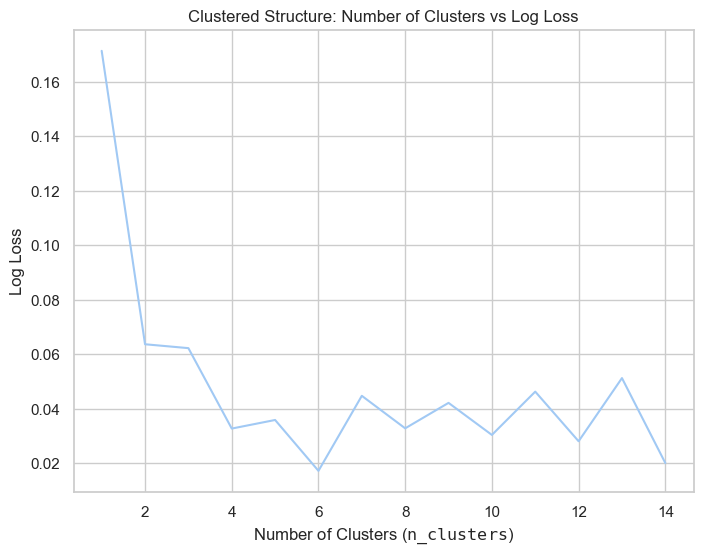

In [24]:
# Plotting n_clusters vs log loss
plt.figure(figsize=(8,6))
plt.plot(n_clusters_options, clus_losses)
plt.xlabel(r"Number of Clusters ($\mathtt{n\_clusters}$)")
plt.ylabel("Log Loss")
plt.title("Clustered Structure: Number of Clusters vs Log Loss")

plt.savefig("sp2-C.pdf", dpi=300, bbox_inches='tight')

# Comparing Structures

In [19]:
# Number of trials
n_trials = 20

metrics = {
    'random': {
        'log_loss': np.zeros(n_trials),
        'precision': np.zeros(n_trials),
        'recall': np.zeros(n_trials),
        'f1_score': np.zeros(n_trials),
        'n_connections': np.zeros(n_trials),
        'in_degree': np.zeros(n_trials),
        'out_degree': np.zeros(n_trials)
    },
    'preferential': {
        'log_loss': np.zeros(n_trials),
        'precision': np.zeros(n_trials),
        'recall': np.zeros(n_trials),
        'f1_score': np.zeros(n_trials),
        'n_connections': np.zeros(n_trials),
        'in_degree': np.zeros(n_trials),
        'out_degree': np.zeros(n_trials)
    },
    'clustered': {
        'log_loss': np.zeros(n_trials),
        'precision': np.zeros(n_trials),
        'recall': np.zeros(n_trials),
        'f1_score': np.zeros(n_trials),
        'n_connections': np.zeros(n_trials),
        'in_degree': np.zeros(n_trials),
        'out_degree': np.zeros(n_trials)
    }
}


for i in range(n_trials):
    rand_loss, rand_precision, rand_recall, rand_f1, rand_conn = random_structure(0.2, True)
    pref_loss, pref_precision, pref_recall, pref_f1, pref_conn = preferential_structure(5, other_metrics=True)
    clus_loss, clus_precision, clus_recall, clus_f1, clus_conn = clustered_structure(6, other_metrics=True)
    
    
    metrics['random']['log_loss'][i] = rand_loss
    metrics['random']['precision'][i] = rand_precision
    metrics['random']['recall'][i] = rand_recall
    metrics['random']['f1_score'][i] = rand_f1
    metrics['random']['n_connections'][i] = np.sum(rand_conn)
    metrics['random']['in_degree'][i] = np.mean(np.sum(rand_conn, axis=1))
    metrics['random']['out_degree'][i] = np.mean(np.sum(rand_conn, axis=0))

    metrics['preferential']['log_loss'][i] = pref_loss
    metrics['preferential']['precision'][i] = pref_precision
    metrics['preferential']['recall'][i] = pref_recall
    metrics['preferential']['f1_score'][i] = pref_f1
    metrics['preferential']['n_connections'][i] = np.sum(pref_conn)
    metrics['preferential']['in_degree'][i] = np.mean(np.sum(pref_conn, axis=1))
    metrics['preferential']['out_degree'][i] = np.mean(np.sum(pref_conn, axis=0))

    metrics['clustered']['log_loss'][i] = clus_loss
    metrics['clustered']['precision'][i] = clus_precision
    metrics['clustered']['recall'][i] = clus_recall
    metrics['clustered']['f1_score'][i] = clus_f1
    metrics['clustered']['n_connections'][i] = np.sum(clus_conn)
    metrics['clustered']['in_degree'][i] = np.mean(np.sum(clus_conn, axis=1))
    metrics['clustered']['out_degree'][i] = np.mean(np.sum(clus_conn, axis=1))
 

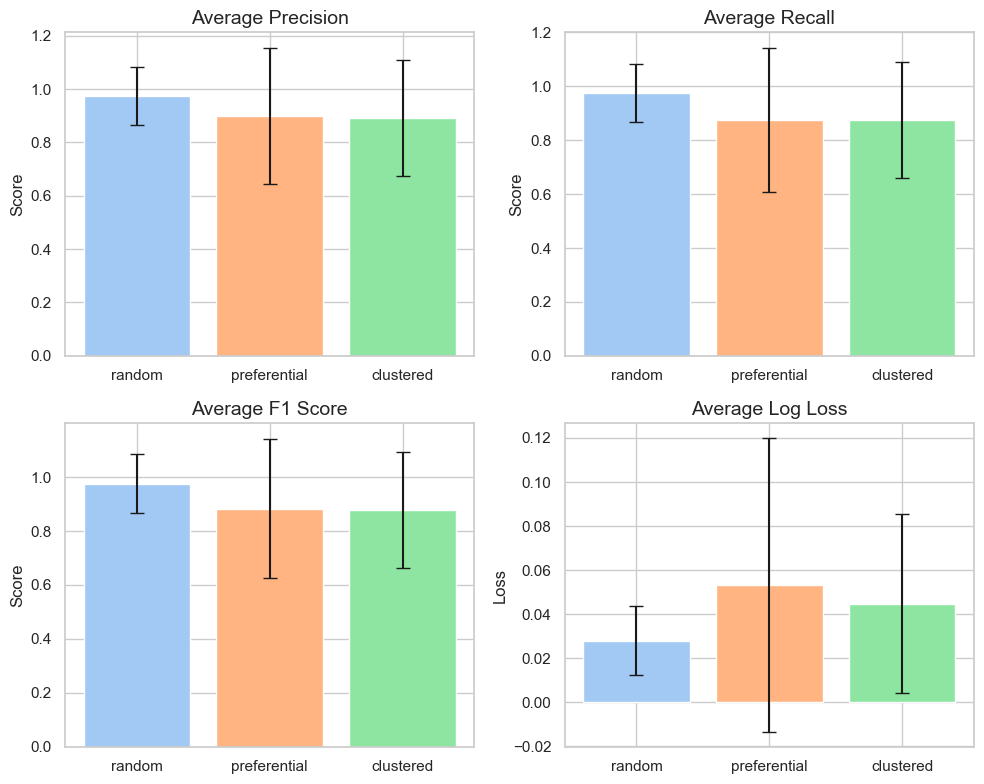

In [25]:
metric_names = ['precision', 'recall', 'f1_score', 'log_loss']  # Log loss moved to last
structures = ['random', 'preferential', 'clustered']
colors = sns.color_palette('pastel', n_colors=3)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for idx, metric in enumerate(metric_names):
    means = [np.nanmean(metrics[struct][metric]) for struct in structures]
    stds = [np.nanstd(metrics[struct][metric]) for struct in structures]  # Standard deviation

    axs[idx].bar(structures, means, yerr=stds, capsize=5, color=colors)
    axs[idx].set_title(f'Average {metric.replace("_", " ").title()}', fontsize=14)
    axs[idx].set_ylabel("Loss" if metric == "log_loss" else "Score")
    

plt.tight_layout()
plt.savefig("sp2-D.pdf", dpi=300, bbox_inches='tight')

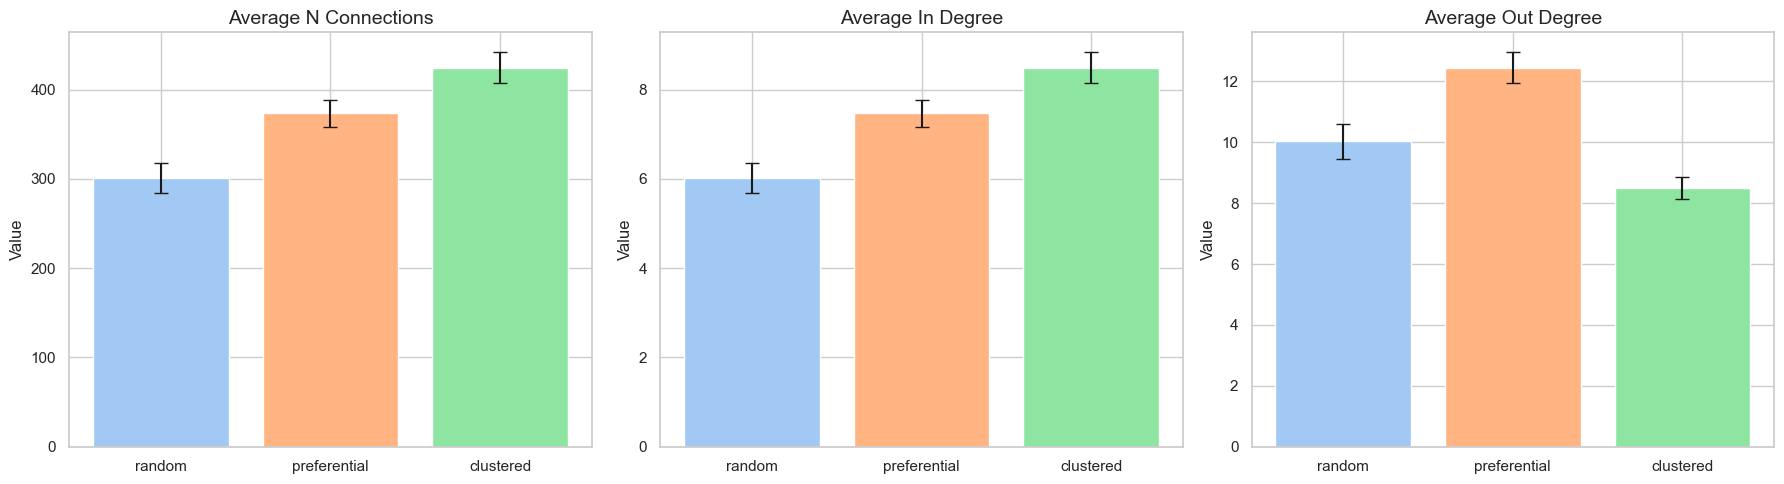

In [28]:
n_connections_data = ['n_connections', 'in_degree', 'out_degree']

fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5))
axs2 = axs2.flatten()

for idx, metric in enumerate(n_connections_data):
    means = [np.nanmean(metrics[struct][metric]) for struct in structures]
    stds = [np.nanstd(metrics[struct][metric]) for struct in structures]

    axs2[idx].bar(structures, means, yerr=stds, capsize=5, color=colors)
    axs2[idx].set_title(f'Average {metric.replace("_", " ").title()}', fontsize=14)
    axs2[idx].set_ylabel("Value")
    axs2[idx].set_ylim(bottom=0) 

plt.tight_layout()
plt.savefig("sp2-E.pdf", dpi=300, bbox_inches='tight')

## Out Degree
- again random structure

In [34]:
n_disease = 15
n_test = 25
expected_number_of_diseases = 2
prev = np.full(n_disease, expected_number_of_diseases/n_disease)
sparseness = 0.3

In [43]:
out_degree_options = np.arange(1, 20)

n_trials = 10

i_trials = len(out_degree_options)
j_trials = n_trials

f1s = np.empty(i_trials)
losses = np.empty(i_trials)

losses_trial = np.empty(j_trials)
f1_trial = np.empty(j_trials)

for i, deg in enumerate(out_degree_options):
    print(i)
    
    
    # Connections matrix ensures that each disease is connected with deg findings
    connections = np.zeros((n_test, n_disease), dtype=int)
    for d in range(n_disease):
        connected_tests = np.random.choice(n_test, size=deg, replace=False)
        connections[connected_tests, d] = 1 
        
    sensorig = np.full((n_test, n_disease), sensitivity ) * connections
    
    
    for j in range(n_trials):

        flag = 1
        attempt = 0
        max_att = 5000

        while flag and attempt<max_att:
            # Forces constant ndiags=2
            actualdiags = np.random.choice(n_disease, size=2, replace=False)  # Generate diseases
            ndiags = len(actualdiags)

            testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

            postest = np.where(testresults == 1)[0]
            negtest = np.where(testresults == 0)[0]
            m = len(postest)

            if 4<m<7:
                flag = 0  # Exit loop if conditions met
#                 print(f"m: {m}, ndiags: {ndiags}")
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
    #         else:
    # #             print(f"ndiags:{ndiags}")
    #              print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")
            attempt += 1

        if flag:
            print("Failed to find valid test result configuration.")

        # Prepare data for Quickscore algorithm
        sens = sensorig[postest, :]                 
        sensneg = sensorig[negtest, :] 

        pfmin = 1 - sens    

        pfminneg = np.prod(1 - sensneg, axis=0)     

        # Quickscore calculation
        posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

        actualdiseases = np.zeros_like(prev)
        actualdiseases[actualdiags] = 1

        # Metric Calculation
        metrics = compute_metrics(actualdiseases, posteriorg)
        
        losses_trial[j] = metrics["log_loss"]
        f1_trial[j] = metrics["f1_score"]
    
    losses[i] = np.mean(losses_trial)
    f1s[i] = np.mean(f1_trial)

0
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
1
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
Failed to find valid test result configuration.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16

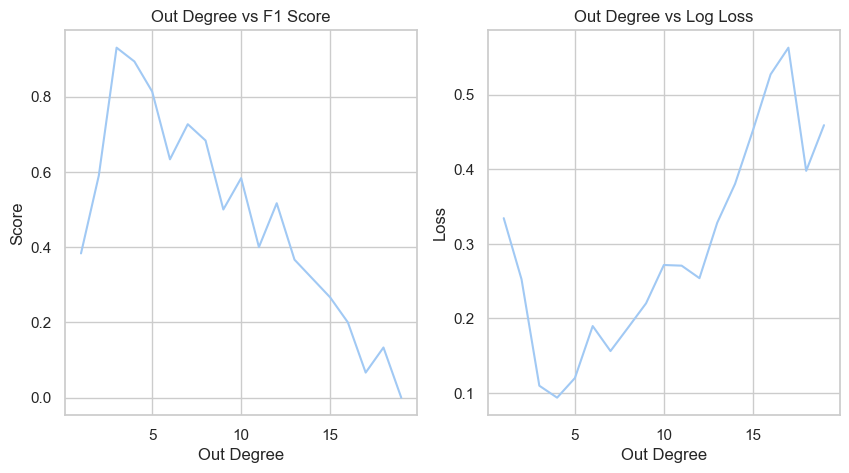

In [44]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(out_degree_options, f1s)
axes[0].set_title("Out Degree vs F1 Score")
axes[0].set_xlabel("Out Degree")
axes[0].set_ylabel("Score")

axes[1].plot(out_degree_options, losses)
axes[1].set_title("Out Degree vs Log Loss")
axes[1].set_xlabel("Out Degree")
axes[1].set_ylabel("Loss")

plt.savefig("sp2-F.pdf", dpi=300, bbox_inches='tight')

## In degree


In [37]:
in_degree_options = np.arange(1, 10)

n_trials = 10

i_trials = len(in_degree_options)
j_trials = n_trials

f1s = np.empty(i_trials)
losses = np.empty(i_trials)

losses_trial = np.empty(j_trials)
f1_trial = np.empty(j_trials)

for i, deg in enumerate(in_degree_options):
    print(i)
    
    
    # Connections matrix ensures that each disease is connected with deg findings
    connections = np.zeros((n_test, n_disease), dtype=int)
    for t in range(n_test):
        connected_diseases = np.random.choice(n_disease, size=deg, replace=False)
        connections[t, connected_diseases] = 1 
        
    sensorig = np.full((n_test, n_disease), sensitivity ) * connections
    
    
    for j in range(n_trials):
        
    
        flag = 1
        attempt = 0
        max_att = 5000

        while flag and attempt<max_att:
            # Forces constant ndiags=2
            actualdiags = np.random.choice(n_disease, size=2, replace=False)  # Generate diseases
            ndiags = len(actualdiags)

            testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

            postest = np.where(testresults == 1)[0]
            negtest = np.where(testresults == 0)[0]
            m = len(postest)

            if 4<m<7:
                flag = 0  # Exit loop if conditions met
#                 print(f"m: {m}, ndiags: {ndiags}")
    #             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
    #         else:
    # #             print(f"ndiags:{ndiags}")
    #              print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")
            attempt += 1

        if flag:
            print("Failed to find valid test result configuration.")

        # Prepare data for Quickscore algorithm
        sens = sensorig[postest, :]                 
        sensneg = sensorig[negtest, :] 

        pfmin = 1 - sens    

        pfminneg = np.prod(1 - sensneg, axis=0)     

        # Quickscore calculation
        posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

        actualdiseases = np.zeros_like(prev)
        actualdiseases[actualdiags] = 1

        # Metric Calculation
        metrics = compute_metrics(actualdiseases, posteriorg)
        
        losses_trial[j] = metrics["log_loss"]
        f1_trial[j] = metrics["f1_score"]
    
    losses[i] = np.mean(losses_trial)
    f1s[i] = np.mean(f1_trial)

0
1
2
3
4
5
6
7
8


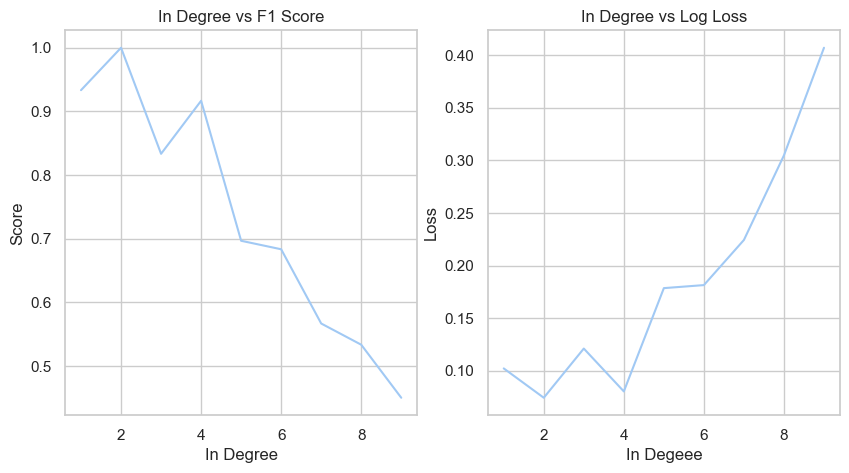

In [41]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(in_degree_options, f1s)
axes[0].set_title("In Degree vs F1 Score")
axes[0].set_xlabel("In Degree")
axes[0].set_ylabel("Score")

axes[1].plot(in_degree_options, losses)
axes[1].set_title("In Degree vs Log Loss")
axes[1].set_xlabel("In Degeee")
axes[1].set_ylabel("Loss")

plt.savefig("sp2-G.pdf", dpi=300, bbox_inches='tight')

# Per Disease Analysis

### Out Degree

In [39]:
n_trials = 10

out_degree_options = np.arange(1, 17)
out_degree_other = 10  # fixed number of connections for diseases

disease_results = np.empty((n_disease, len(out_degree_options)))

for i in range(n_disease):
    print(i)
    errors_per_degree = np.empty(len(out_degree_options))
    
    other_diseases_ind = np.delete(np.arange(n_disease), i)
    
    connections = np.zeros((n_test, n_disease), dtype=bool)
    for d in range(n_disease):
        if d !=i:
            idx = np.random.choice(n_test, out_degree_other , replace=False)
            connections[idx,d] = True
    
    for j, deg in enumerate(out_degree_options):
        
        idx = np.random.choice(n_test, deg, replace=False)
        connections[idx,i] = True
        
        sensorig = np.full((n_test, n_disease), sensitivity ) * connections
        
        trial_errors = np.empty(n_trials)
        
        for t in range(n_trials):
            flag = 1
            attempt = 0
            max_att = 3000

            while flag and attempt<max_att:
                # Forces disease i to be present, and one of the ndiags=2 diseases
                d2 = np.random.choice(other_diseases_ind)  # other positive disease
                actualdiags = [i, d2]
                ndiags = len(actualdiags)

                testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

                postest = np.where(testresults == 1)[0]
                negtest = np.where(testresults == 0)[0]
                m = len(postest)

                if 4 < m < 7:
                    flag = 0  # Exit loop if conditions met
#                     print(f"m: {m}, ndiags: {ndiags}")
        #             print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
        #         else:
        # #             print(f"ndiags:{ndiags}")
        #              print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")
                attempt += 1

            if flag:
                print("Failed to find valid test result configuration.")
                trial_errors[t] = np.nan

            # Prepare data for Quickscore algorithm
            sens = sensorig[postest, :]                 
            sensneg = sensorig[negtest, :] 
            pfmin = 1 - sens    
            pfminneg = np.prod(1 - sensneg, axis=0)     

            # Quickscore calculation
            posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

            actualdiseases = np.zeros_like(prev)
            actualdiseases[actualdiags] = 1

            # Metric Calculation
        #     metrics = compute_metrics(actualdiseases, posteriorg)
            trial_errors[t] = (1 - posteriorg[i])**2 # disease is always positive
    
        errors_per_degree[j] = np.nanmean(trial_errors)
    
    disease_results[i,:] = errors_per_degree

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


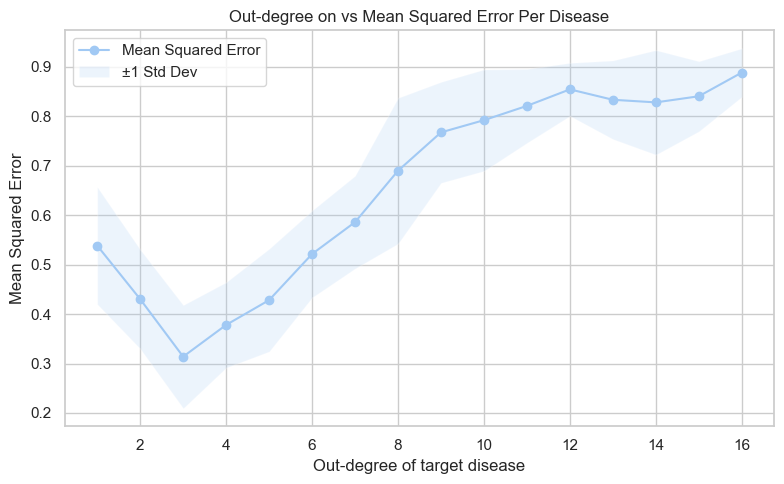

In [42]:
# Mean across diseases
mean_errors = np.nanmean(disease_results, axis=0)
std_errors = np.nanstd(disease_results, axis=0)

# Plot
plt.figure(figsize=(8,5))
plt.plot(out_degree_options, mean_errors, label='Mean Squared Error', marker='o')
plt.fill_between(out_degree_options, mean_errors - std_errors, mean_errors + std_errors, alpha=0.2, label='±1 Std Dev')

plt.xlabel('Out-degree of target disease')
plt.ylabel('Mean Squared Error')
plt.title('Out-degree on vs Mean Squared Error Per Disease')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("sp2-H.pdf", dpi=300, bbox_inches='tight')